### Project Description:

The aim of the assignment is to perform clustering on the breast cancer dataset to explore patterns and groupings in the data to explore if there are distinct subtypes of breast cancer based on their clinical features?

To do this aim, I did these steps in the following:

1- Data Loading and Preprocessing

2- K-Means Clustering

3- Visualization with Dimension Reduction

4- Hyperparameter Tuning and Evaluation

5- Comparison of Clustering Algorithms

#### loading and preparing data

To assess a structure of the breast cancer dataset, the following steps were done:

1- load the data

2- inspecting its shape. The shape attribute of the loaded dataset helps to get the information about the number of observations (samples) and features (attributes) in the dataset. By getting shape we understand the balance between observations and features. If we have a balanced dataset, therefore we could be sure that we have proper data for clustering and gain meaningful patterns.

3- checking data (head command) and compare it with the data type of columns are also usefull to reach if data are in the correct format.

4- check the normalization of data. By checking this we can understand the preprocessing approach.

In [1]:
import pandas as pd
import yaml

#Import the data

configPath = 'config.yaml'

# Read the yaml data from the file
with open(configPath, 'r') as file:
    configData = yaml.safe_load(file)

df = pd.read_csv(configData["breast_cancer_path"])

print(df.shape) # get the size of data


(569, 32)


In [2]:
print(df.head()) # Display the first few rows of the dataset

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [3]:
print(df.dtypes) # get the type of columns

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

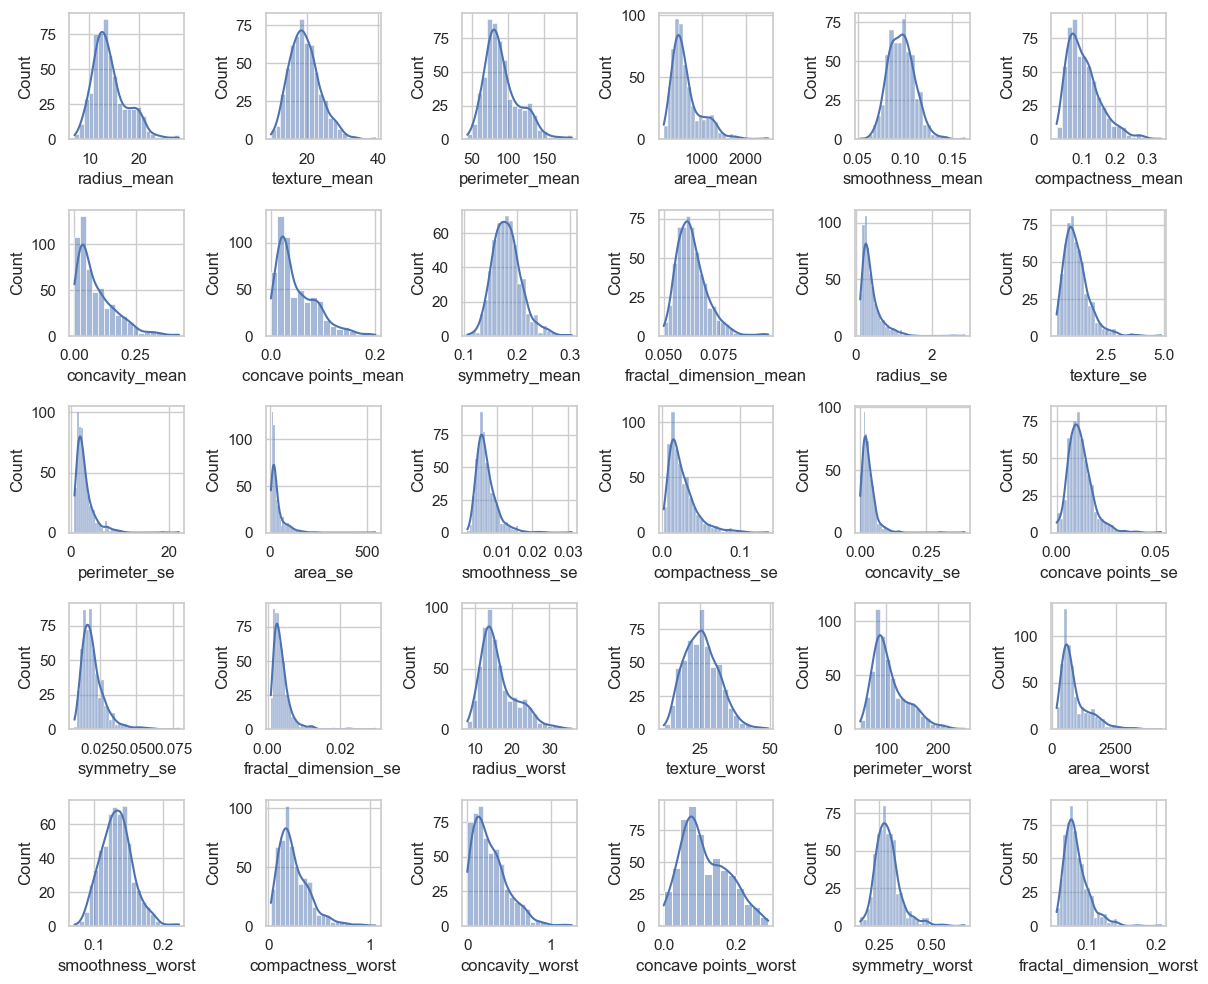

In [4]:
# Plot histograms of each feature
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))
for i, column in enumerate(df.columns[2:], 1): #diagnose field is not plotted because it is categorical variable
    plt.subplot(5, 6, i)
    sns.histplot(df[column], kde=True)
    plt.xlabel(column)
plt.tight_layout()
plt.show()

#### preprocessing data

from the above 'diagnosis' is a categorical field and other with float type are features; So I assume 'diagnosis' as a dependent variable. 

Besides, as in the above showed, data has a right tail and have not normal normalization. So I used scale data to prevent of harming the rest of process regarding their wide variation. 

Regarding the above results, Firstly I seprate the diagnonsis as a dependent variable (Y) and then scale other features. and finally concat the Y to the final scaled data.

In [5]:
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']

In [6]:
#from sklearn.preprocessing import StandardScaler

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the scaled features
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Concatenate the scaled features with the target variable
df_preprocessed = pd.concat([df_scaled, y], axis=1)

# Display the first few rows of the preprocessed dataset
print(df_preprocessed.head())


         id  radius_mean  texture_mean  perimeter_mean  area_mean  \
0 -0.236405     1.097064     -2.073335        1.269934   0.984375   
1 -0.236403     1.829821     -0.353632        1.685955   1.908708   
2  0.431741     1.579888      0.456187        1.566503   1.558884   
3  0.432121    -0.768909      0.253732       -0.592687  -0.764464   
4  0.432201     1.750297     -1.151816        1.776573   1.826229   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         1.568466          3.283515        2.652874             2.532475   
1        -0.826962         -0.487072       -0.023846             0.548144   
2         0.942210          1.052926        1.363478             2.037231   
3         3.283553          3.402909        1.915897             1.451707   
4         0.280372          0.539340        1.371011             1.428493   

   symmetry_mean  ...  texture_worst  perimeter_worst  area_worst  \
0       2.217515  ...      -1.359293         2.303601

#### define a pipeline with preprocessing and clustering

Regarding to the assignment question written in the begining (if there are distinct subtypes of breast cancer based on their clinical features?) and since we don't have any definition for probability subtypes so supervise method was chosen and the common method to recognize clustering is k-mean.

These clusters may help in representing groups of patients with distinct clinical characteristics, leading to a deeper understanding of disease and their treatment.

if we want to find the better K for clustering in the Kmean we could fit kmean with cluster values in wide rang (1:20). (elbow method) and plotting cluster number vs inertia (sum of squared distances of samples to their closest cluster center).

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


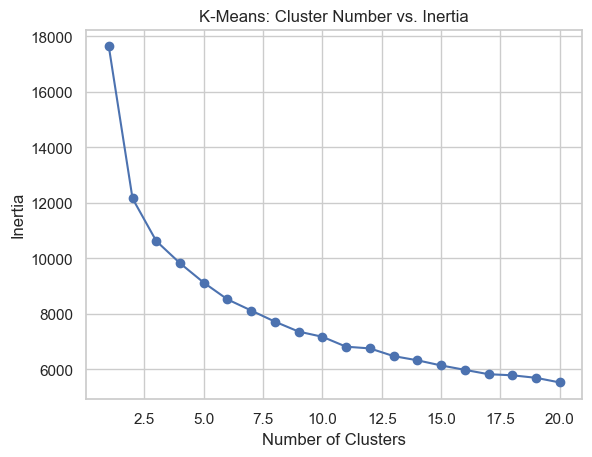

In [9]:
import numpy as np
from sklearn.cluster import KMeans

X_scaled = scaler.fit_transform(X)

# Define the range of cluster values
cluster_values = range(1, 21)

# Initialize lists to store the number of clusters and inertia values
num_clusters = []
inertia_values = []

# Iterate over the cluster values
for k in cluster_values:
    # Create a KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Fit the model to the data
    kmeans.fit(X_scaled)
    
    # Append the number of clusters and inertia value to the respective lists
    num_clusters.append(k)
    inertia_values.append(kmeans.inertia_)

# Plot cluster number vs. inertia
plt.plot(num_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means: Cluster Number vs. Inertia')
plt.show()

from the result it suggested that 3 clustering could be proper for k-mean method.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Separate the features and target variable
X = df_preprocessed.drop(['diagnosis'], axis=1)
y = df_preprocessed['diagnosis']

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step: feature scaling
    ('clustering', KMeans(n_clusters=3))  # Clustering algorithm: KMeans
])

# Fit the pipeline to the data
pipeline.fit(X)

# Perform clustering and obtain the labels
cluster_labels = pipeline.predict(X)

# Display the cluster labels
print(cluster_labels)

[2 2 2 1 2 1 2 1 1 1 0 1 2 0 1 1 0 1 2 0 0 0 1 2 2 2 1 2 1 2 2 1 2 2 1 1 1
 0 0 1 0 1 2 1 0 2 0 1 0 0 0 0 0 2 0 0 2 1 0 0 0 0 1 0 1 1 0 0 1 0 2 1 1 0
 0 2 0 2 2 0 0 1 2 2 0 2 0 2 0 1 0 0 0 0 1 2 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0
 1 1 0 0 0 0 1 1 0 0 2 2 0 0 0 0 2 1 2 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 1 1 0
 0 0 0 1 1 0 0 0 2 0 0 0 0 2 2 0 2 0 0 0 2 0 0 0 1 0 0 0 1 1 0 0 2 2 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 2 2 1 0 2 2 1 0 0 0 0 1 0 2 0 2 1 1 1 1 0 2 2 0 0
 0 1 0 0 0 0 0 1 1 0 0 2 0 0 2 2 0 2 0 0 1 0 2 0 0 1 0 0 2 0 2 0 2 0 2 1 2
 1 2 0 2 0 2 2 0 0 0 1 0 0 2 0 0 0 0 0 0 0 2 0 2 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 2 0 2 0 0 0 0 1 1 1 0 0
 0 0 2 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 1 2 1 0 0 1 0 0 0 0 0 0 0 0 2 2 0 2 2
 1 0 2 2 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 2 0 0 1 2 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 1 0 2 2 0 1 0 0 0 0 1 2 0 0
 0 0 2 0 0 2 0 2 0 0 0 0 0 0 0 0 2 2 0 0 0 1 0 0 2 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 2 0 0 0 0 2 

The aboved result shows the 3 different cluster based on bio characters on the refrence dataset named 0, 1, 2. As understanding the diagnosis status in these cluster I used the above grouping to undesrtand the distribution of the diagonsis in them. 

In [11]:
#create new dataframe to save clustering result and diagnosis
df_kmean_inv = pd.DataFrame()
df_kmean_inv['cluster'] = cluster_labels
df_kmean_inv['diagnosis'] = y

# Examine the clusters by counting the number of Malignant (M) and Benign (B) samples in each cluster
print(df_kmean_inv.groupby(['cluster', 'diagnosis']).size())

cluster  diagnosis
0        B            321
         M             38
1        B             36
         M             64
2        M            110
dtype: int64


As the above result shows, in the third clustering we just have 'M' category of diagnosis. and most observations are in 'B' type in the first clustering.

To understand the validation of the result, I used Silhouette method which measures the similarity of each data point to its assigned cluster compared to neighboring clusters. 

In [12]:
# Silhouette Score
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, cluster_labels)

# Display the silhouette score
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.3067956711053563


A Silhouette Score of 0.3067 is moderately positive, shows that there is some degree of separation among the clusters, but there is also room for improvement.

#### Dimension reduction and visualization with pca and tsne

To visualize the clustering result in the following PCA and Tsne with 2 components are used. 2 components were chosen because it is common choice in a 2D space to visualize the data points and their clustering relationship more easily. Also, usually, 2 first components capture the most variances.

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Perform dimension reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Perform dimension reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)


c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


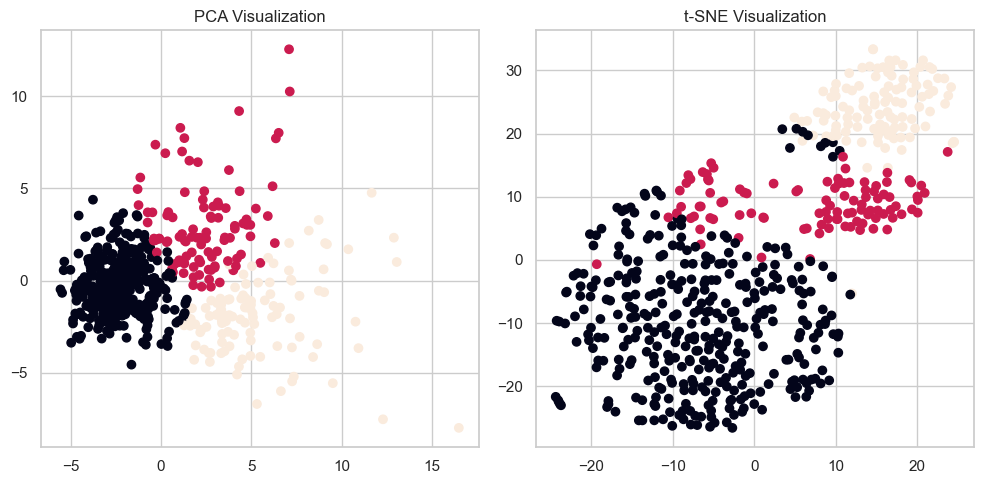

In [14]:
# Visualize using PCA
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.title('PCA Visualization')

# Visualize using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels)
plt.title('t-SNE Visualization')

# Display the plot
plt.tight_layout()
plt.show()

both diagram show the observed datapoints in reduced space with first and second components (features). and each color shows the cluster of the datapoint. The result of these diagram are similar by the result of the silhouette Score. Because data are mostly in their cluster and there is just a few noise and overfitting between them.

if we want to improve kmean result, one of the ways is checking the features and choose the most relevent components to prevent of effecting quality of clustering by features, we could cumulative pca results of the components.

In [15]:
pca = PCA() #I don't mention the number of component to calculate all
X_pca = pca.fit_transform(X)

variance_ratio = np.cumsum(pca.explained_variance_ratio_)

print(f'all components are: {len(variance_ratio)} and the status of covring the variance are shown in the following: \n {variance_ratio}')

all components are: 31 and the status of covring the variance are shown in the following: 
 [0.42864701 0.61241493 0.70387928 0.76779403 0.82098162 0.86080977
 0.89236698 0.91403643 0.9289007  0.94190499 0.95316806 0.96264839
 0.97107249 0.97885733 0.983921   0.9869574  0.98953192 0.99143664
 0.99313313 0.9947177  0.99571999 0.99668583 0.99757069 0.99835291
 0.99893483 0.99943418 0.99969778 0.9999203  0.99997157 0.99999571
 1.        ]


As shown in the above there are 31 component and depends on the problem we can select the top n components for example if we choose the 0.9 coverage thershold, then it seems 7 first component are suffietient.

Since we eleminate 'diagnosis' feature in the clustering and regarding the shape() command we have 32 columns so the 31 component is correct in the result.

GridSearchCV for hyperparameter

To perform a hyperparameter tuning process to find the optimal hyperparameters for the K-Means clustering algorithm. (the proper clustering number), the GridSearchCv was used. Because if we want to do it manually and fit the model by that it will take a long time and also may not completely accurate. (The aim is to find the value of k that leads to the most meaningful and biologically interpretable clustering solution.)

To initial the method these parameters were used: 
'clustering__n_clusters': [3, 4, 5]: The number of clusters (k) we want the K-Means algorithm to create. (Regarding the elbow method.'s result) 

'clustering__max_iter': [100, 200, 300]: Maximum number of iterations the K-Means algorithm to converge to the final clustering solution.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# pipeline with preprocessing and clustering
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step: feature scaling
    ('clustering', KMeans())  # Clustering algorithm: KMeans
])

# parameter grid for hyperparameter tuning
param_grid = {
    'clustering__n_clusters': [3, 4, 5],  # Number of clusters
    'clustering__init': ['k-means++', 'random'],  # Initialization method
    'clustering__max_iter': [100, 200, 300]  # Maximum number of iterations
}

In [17]:
X5 = X #for sepraring the result of new clustering, I set the X in the X5

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X5)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Fit the best model to the data
best_model.fit(X5)

# Perform clustering and obtain the labels using the best model
cluster_labels5 = best_model.predict(X5)

# Display the best hyperparameters and the cluster labels
print("Best Hyperparameters:", best_params)
print("Cluster Labels:", cluster_labels5)

Best Hyperparameters: {'clustering__init': 'random', 'clustering__max_iter': 100, 'clustering__n_clusters': 5}
Cluster Labels: [4 2 2 1 2 1 2 1 1 1 3 2 4 2 1 1 3 1 2 3 0 0 1 2 2 4 1 2 1 2 4 1 2 2 1 2 1
 3 3 1 3 0 4 1 3 2 0 1 3 3 3 3 3 2 3 3 2 1 3 0 0 0 1 0 1 1 0 3 1 3 2 0 1 3
 3 2 0 4 4 3 0 1 4 2 0 2 0 2 0 0 3 3 3 3 2 2 0 0 3 0 3 0 3 0 0 1 0 3 4 0 0
 0 1 0 0 0 0 1 1 2 3 2 4 3 3 3 3 2 0 2 0 2 2 3 2 3 3 3 2 0 3 2 0 3 3 0 1 0
 3 3 0 1 1 3 0 3 2 3 3 3 0 2 2 0 2 3 3 2 2 3 0 3 1 0 3 0 1 1 3 3 4 4 2 3 3
 0 2 3 3 3 1 3 3 1 1 3 1 2 2 1 0 2 4 1 0 3 0 2 1 3 2 3 4 2 1 1 0 0 2 2 3 0
 0 1 3 3 0 3 3 1 2 3 3 2 0 3 4 2 3 2 3 3 1 3 2 0 3 1 0 0 4 3 4 2 2 0 4 1 4
 1 2 3 2 3 2 4 0 3 3 0 3 3 4 0 2 0 3 2 3 3 2 3 2 1 3 3 0 3 0 3 1 3 0 3 3 3
 3 3 3 0 4 3 4 0 3 3 3 3 3 3 3 3 3 3 0 3 3 2 1 3 0 2 0 4 3 3 3 3 2 2 2 0 0
 3 3 2 0 2 0 4 3 0 0 2 0 0 3 3 0 0 3 1 4 2 3 0 0 3 0 0 3 3 3 3 3 2 4 3 2 4
 1 3 2 2 3 3 1 3 3 1 0 3 3 0 3 3 3 3 0 2 0 0 1 4 0 3 3 3 3 3 1 3 3 3 3 0 3
 3 2 3 3 3 3 3 3 0 0 4 3 3 0 1 0 3 0 3 0 3 3 3 1

By the above results it is concluded that: 

The optimal number of maximum iterations for the K-Means algorithm is 100 and The optimal number of clusters chosen by the GridSearchCV is 5. This means that the K-Means algorithm will create five distinct clusters to group the breast cancer data points. Besides, during the clustering, the algorithm iterates a maximum of 100 times to update the cluster assignments and centroids to ensure that the algorithm converges to a stable solution.

Finaly, the cluster labels obtained using the optimal hyperparameters have been provided as output. Each data point has been assigned to one of the five clusters based on the K-Means algorithm's clustering results.

#### Evaluate performance

The next step is to validate the clustering outcome biologically, as mentioned previously. To interpret the clustering results in the context of known biological subtypes and clinical features is crucial. Additionally, evaluating the clustering performance using evaluation metrics like the Silhouette Score or Calinski-Harabasz Index will further assess the clustering quality and its biological relevance.

In [18]:
# Silhouette Score
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg5 = silhouette_score(X5, cluster_labels5)

# Display the silhouette score
print("Silhouette Score:", silhouette_avg5)

Silhouette Score: 0.15952802599803068


In [19]:
# Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz index
ch_score5 = calinski_harabasz_score(X5, cluster_labels5)

# Display the Calinski-Harabasz index
print("Calinski-Harabasz Index:", ch_score5)

Calinski-Harabasz Index: 131.5940818643953


Silhouette Score: 0.165: This Score shows that the clusters have some degree of separation, but they are not very well-defined. The score is relatively low, indicating that there might be overlapping data points or ambiguous cluster boundaries.

Calinski-Harabasz Index: 131.505: This score shows that there is some degree of separation between the clusters. However, it is important to note that this metric can be influenced by the number of clusters and the distribution of the data.

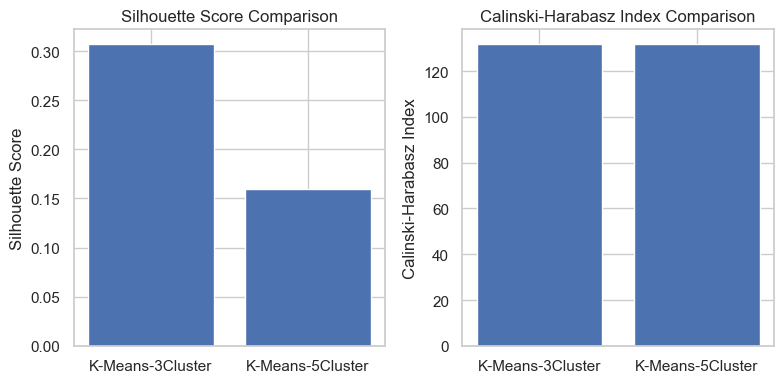

In [21]:
# Method names for the plot
methods = ['K-Means-3Cluster', 'K-Means-5Cluster']
silhouette_scores = [silhouette_avg, silhouette_avg5]
ch_scores = [ch_score5, ch_score5]

# a bar plot for silhouette scores
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.bar(methods, silhouette_scores)
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')

# a bar plot for Calinski-Harabasz index scores
plt.subplot(1, 2, 2)
plt.bar(methods, ch_scores)
plt.title('Calinski-Harabasz Index Comparison')
plt.ylabel('Calinski-Harabasz Index')

# Display the plot
plt.tight_layout()
plt.show()


However we fount 5 cluster from the gridsearchcv but according to the plot we found kmean by 3 cluster has the better result in the clustering. This might because:

GridSearchCV tries different hyperparameter combinations and evaluates the clustering performance using cross-validation. It takes into account the internal structure of the data and the cluster quality measures. It's possible that GridSearchCV found that 5 clusters have better performance according to the chosen evaluation metric (e.g., silhouette score) compared to the inertia-based elbow method. (3-clustering was based on elbow method)

But as previously mentioned in both clustering, both clustering has some room to improve. It might be beneficial to explore alternative clustering algorithms, adjust the number of clusters, or consider feature engineering or selection techniques to enhance the clustering performance and uncover more meaningful patterns in the breast cancer data.